# Analysis for the experiments on the TSCP scenario

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from itertools import combinations

In [2]:
# Settings
fileName = "resultsTSCP.csv"
orderingStrategyPMedici = "IN_ORDER_SIZE_DESC"

In [3]:
# Load the file into a pandas dataframe
df = pd.read_csv(fileName, names=['Generator','ModelName','PercentageOfOldTsKept','TSSize','TSTime','Strength','Ordering'], header=0, index_col=False, delimiter=';')	
# Set Ordering to empty string where it is NaN
df['Ordering'].fillna('', inplace=True)

## Group all executions

In [4]:
# Group data in df by Generator, ModelName, PercentageOfOldTsKept, Strength, and Ordering. For the TSSize and TS time, take the mean
df = df.groupby(['Generator','ModelName','PercentageOfOldTsKept','Strength','Ordering']).agg({'TSSize':'mean', 'TSTime':'mean'}).reset_index()
# Remove from df all the lines where generator is pMEDICI or pMEDICI+ but Ordering is not equal to orderingStrategyPMedici
dfFiltered = df[~(df['Generator'].str.contains('pMEDICI')) | (df['Generator'].str.contains('pMEDICI') & (df['Ordering'] == orderingStrategyPMedici))]

In [5]:
# Count and print the number of timeouts per Generator
print(dfFiltered[dfFiltered['TSTime'] == -1].groupby(['Generator']).agg({'TSTime':'count'}))

           TSTime
Generator        
PICT          110
pMEDICI        66
pMEDICI+       66


In [6]:
# Set all timeouts (TSTime = -1) to TSTime = 300001 and with Size = MAX Size
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSSize'] = 100000
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSTime'] = 301000

# Remove all the rows corresponding to models for which at least one of the generators timed out
# dfFiltered = dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])]

In [7]:
# Print the average time and size for each Generator
print(dfFiltered.groupby(['Generator']).agg({'TSSize':'mean', 'TSTime':'mean'}))

                 TSSize        TSTime
Generator                            
ACTS         105.533818   9305.420000
PICT       20079.350182  60757.706909
pMEDICI    12134.221455  37366.713818
pMEDICI+   12099.640000  37321.546545


## How does the execution time change depending on the PercentageOfTsKept?

Text(0, 0.5, 'Time difference [ms]')

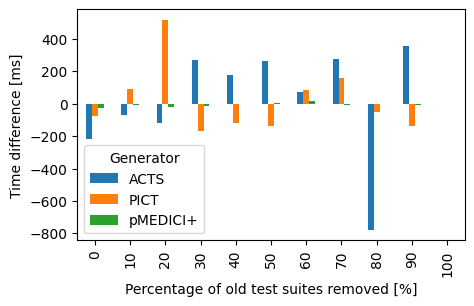

In [8]:
# Build a dataframe with for each model and PercentageOfOldTsKept the difference between the time required by the generator with PercentageOfOldTsKept = 100 and that with the selected PercentageOfOldTsKept
dfDiff = pd.DataFrame(columns=['ModelName','PercentageOfOldTsKept','TSTimeDiff', 'Generator'])
for generator in dfFiltered['Generator'].unique():
    if (generator == 'pMEDICI'):
        continue
    for modelName in dfFiltered['ModelName'].unique():
        for percentageOfOldTsKept in dfFiltered['PercentageOfOldTsKept'].unique():
            dfDiff.loc[len(dfDiff), dfDiff.columns] = {'ModelName':modelName, 
                                                    'PercentageOfOldTsKept':percentageOfOldTsKept, 
                                                    'Generator':generator,
                                                    'TSTimeDiff':dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == percentageOfOldTsKept) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSTime'].iloc[0] 
                                                                 - 
                                                                 dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == 100) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSTime'].iloc[0]
                                                    }
        
# Average the TSTimeDiff for each model over the different values of PercentageOfOldTsKept
dfDiff = dfDiff.groupby(['PercentageOfOldTsKept', 'Generator']).agg({'TSTimeDiff':'mean'}).reset_index()

# Barplot showing the distribution of the TSTimeDiff for each PercentageOfOldTsKept and for each Generator
ax = dfDiff.pivot(index='PercentageOfOldTsKept', columns='Generator', values='TSTimeDiff').plot.bar(figsize=(5,3))

# ax = dfDiff.sort_values(by = 'PercentageOfOldTsKept').plot.bar(x='PercentageOfOldTsKept', y='TSTimeDiff', figsize=(5,3))
ax.set_xlabel("Percentage of old test suites removed [%]")
ax.set_ylabel("Time difference [ms]")

## How does the test suite size change depending on the PercentageOfTsKept?

Text(0.5, 0, 'Percentage of old test suites removed')

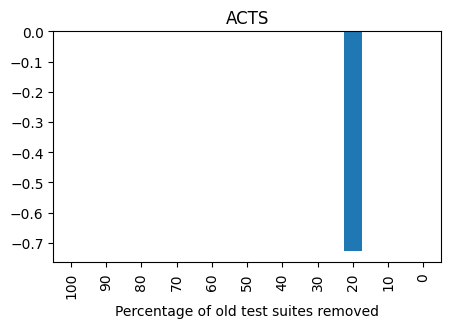

In [11]:
# Build a dataframe with for each model and PercentageOfOldTsKept the difference between the time required by the generator with PercentageOfOldTsKept = 100 and that with the selected PercentageOfOldTsKept
dfDiff = pd.DataFrame(columns=['ModelName','PercentageOfOldTsKept','TSSizeDiff', 'Generator'])
for generator in dfFiltered['Generator'].unique():
    if (generator == 'pMEDICI'):
        continue
    for modelName in dfFiltered['ModelName'].unique():
        for percentageOfOldTsKept in dfFiltered['PercentageOfOldTsKept'].unique():
            dfDiff.loc[len(dfDiff), dfDiff.columns] = {'ModelName':modelName, 
                                                    'PercentageOfOldTsKept':percentageOfOldTsKept, 
                                                    'Generator':generator,
                                                    'TSSizeDiff':dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == percentageOfOldTsKept) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSSize'].iloc[0] 
                                                                 - 
                                                                 dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == 100) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSSize'].iloc[0]
                                                    }
        
# Average the TSTimeDiff for each model over the different values of PercentageOfOldTsKept
dfDiff = dfDiff.groupby(['PercentageOfOldTsKept', 'Generator']).agg({'TSSizeDiff':'mean'}).reset_index()

# Barplot showing the distribution of the TSTimeDiff for each PercentageOfOldTsKept and for each Generator
ax = dfDiff.pivot(index='PercentageOfOldTsKept', columns='Generator', values='TSSizeDiff').plot.bar(figsize=(5,3))

# ax = dfDiff.sort_values(by = 'PercentageOfOldTsKept').plot.bar(x='PercentageOfOldTsKept', y='TSTimeDiff', figsize=(5,3))
ax.set_xlabel("Percentage of old test suites removed [%]")
ax.set_ylabel("Size difference [# test cases]")

Text(0.5, 0, 'Percentage of old test suites removed')

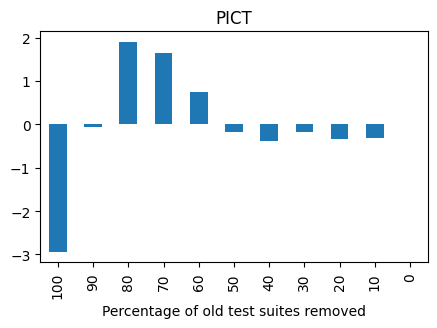

In [12]:
# Build a dataframe with for each model and PercentageOfOldTsKept the difference between the time required by the PICT generator with PercentageOfOldTsKept = 0 and that with the selected PercentageOfOldTsKept
dfDiff = pd.DataFrame(columns=['ModelName','PercentageOfOldTsKept','TSSizeDiff'])
for modelName in dfFiltered['ModelName'].unique():
    for percentageOfOldTsKept in dfFiltered['PercentageOfOldTsKept'].unique():
        dfDiff.loc[len(dfDiff), dfDiff.columns] = {'ModelName':modelName, 
                                                   'PercentageOfOldTsKept':percentageOfOldTsKept, 
                                                   'TSSizeDiff':dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == percentageOfOldTsKept) & (dfFiltered['Generator'] == 'PICT')]['TSSize'].iloc[0] - dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == 100) & (dfFiltered['Generator'] == 'PICT')]['TSSize'].iloc[0]
                                                }
        
# Average the TSSizeDiff for each model over the different values of PercentageOfOldTsKept
dfDiff = dfDiff.groupby(['PercentageOfOldTsKept']).agg({'TSSizeDiff':'mean'}).reset_index()

dfDiff['PercentageOfOldTsKept'] = 100 - df['PercentageOfOldTsKept']
    
# Plot on the x axis the ModelName and on the y axis the dfDiff for the ACTS Generator, sorted by TSTime, using a different serie for each PercentageOfOldTsKept
ax = dfDiff.plot(x='PercentageOfOldTsKept', y='TSSizeDiff', kind='bar', title='PICT', figsize=(5,3), legend=False)
ax.set_xlabel("Percentage of old test suites removed")

Text(0.5, 0, 'Percentage of old test suites removed')

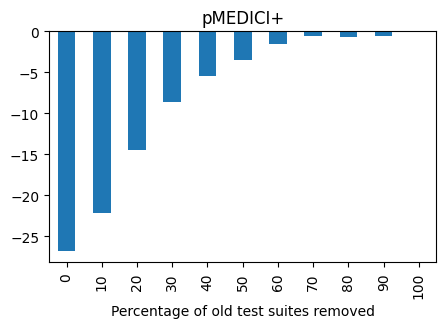

In [13]:
# Build a dataframe with for each model and PercentageOfOldTsKept the difference between the time required by the pMEDICI+ generator with PercentageOfOldTsKept = 0 and that with the selected PercentageOfOldTsKept
dfDiff = pd.DataFrame(columns=['ModelName','PercentageOfOldTsKept','TSSizeDiff'])
for modelName in dfFiltered['ModelName'].unique():
    for percentageOfOldTsKept in dfFiltered['PercentageOfOldTsKept'].unique():
        dfDiff.loc[len(dfDiff), dfDiff.columns] = {'ModelName':modelName, 
                                                   'PercentageOfOldTsKept':percentageOfOldTsKept, 
                                                   'TSSizeDiff':dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == percentageOfOldTsKept) & (dfFiltered['Generator'] == 'pMEDICI+')]['TSSize'].iloc[0] - dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == 100) & (dfFiltered['Generator'] == 'pMEDICI+')]['TSSize'].iloc[0]
                                                }
        
# Average the TSSizeDiff for each model over the different values of PercentageOfOldTsKept
dfDiff = dfDiff.groupby(['PercentageOfOldTsKept']).agg({'TSSizeDiff':'mean'}).reset_index()
    
# Plot on the x axis the ModelName and on the y axis the dfDiff for the ACTS Generator, sorted by TSTime, using a different serie for each PercentageOfOldTsKept
ax = dfDiff.plot(x='PercentageOfOldTsKept', y='TSSizeDiff', kind='bar', title='pMEDICI+', figsize=(5,3), legend=False)
ax.set_xlabel("Percentage of old test suites removed")

## Time analysis

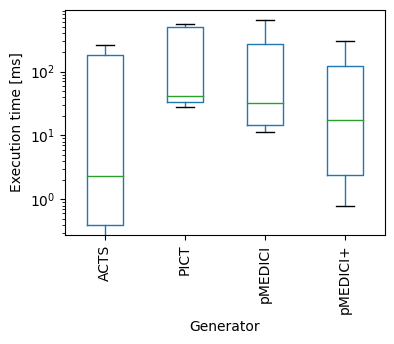

In [14]:
# Extract the execution time of different generators
dfExecutionTime = dfFiltered[['Generator','TSTime']]

# Boxplot the execution time of different generators and remove the outliers
ax = dfExecutionTime.boxplot(by='Generator', showfliers=False, grid=False, rot=90)
ax.set_yscale('log')
ax.set_ylabel('Execution time [ms]')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(4, 3)
# Export the figure in PDF
plt.savefig("pictures/SINC_TS_Time.pdf", bbox_inches='tight')

In [15]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfExecutionTime['Generator'].unique()
for generator1, generator2 in combinations(generators, 2):
    print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfExecutionTime[dfExecutionTime['Generator'] == generator1]['TSTime'], dfExecutionTime[dfExecutionTime['Generator'] == generator2]['TSTime']))

ACTS VS PICT:
 WilcoxonResult(statistic=6193.5, pvalue=1.0813523567642488e-77)
ACTS VS pMEDICI:
 WilcoxonResult(statistic=38137.0, pvalue=6.046723235770954e-24)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=44174.0, pvalue=2.4100884555020022e-17)
PICT VS pMEDICI:
 WilcoxonResult(statistic=47019.0, pvalue=8.745209656028776e-06)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=31968.5, pvalue=2.5287428471822082e-20)
pMEDICI VS pMEDICI+:
 WilcoxonResult(statistic=5275.0, pvalue=3.074902413007361e-67)


## Size analysis

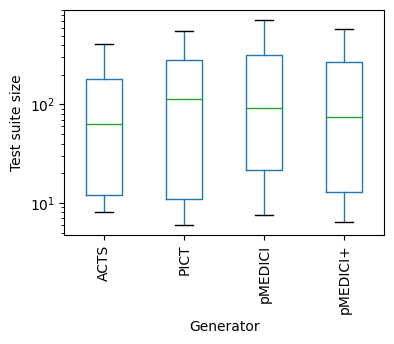

In [16]:
# Extract the TS Size of different generators
dfTSSize = dfFiltered[['Generator','TSSize']]

# Boxplot the TS Size of different generators and remove the outliers
ax = dfTSSize.boxplot(by='Generator', showfliers=False, grid=False, rot=90)
ax.set_yscale('log')
ax.set_ylabel('Test suite size')
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(4, 3)
# Export the figure in PDF
plt.savefig("pictures/SINC_TS_Size.pdf", bbox_inches='tight')

In [17]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfTSSize['Generator'].unique()
for generator1, generator2 in combinations(generators, 2):
    if not (generator1 in ['ACTS', 'ACTS W SEEDS'] and generator2 in ['ACTS', 'ACTS W SEEDS']):
        print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfTSSize[dfTSSize['Generator'] == generator1]['TSSize'], dfTSSize[dfTSSize['Generator'] == generator2]['TSSize'], zero_method='zsplit'))

ACTS VS PICT:
 WilcoxonResult(statistic=42199.0, pvalue=2.0283171574392003e-19)
ACTS VS pMEDICI:
 WilcoxonResult(statistic=1933.5, pvalue=2.9216150786578945e-87)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=10904.5, pvalue=7.81496908863975e-68)
PICT VS pMEDICI:
 WilcoxonResult(statistic=29387.0, pvalue=1.595842097612901e-35)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=33257.5, pvalue=3.4738219595255636e-30)
pMEDICI VS pMEDICI+:
 WilcoxonResult(statistic=5226.0, pvalue=7.321882738843024e-80)
